# Simulating the D. montana D. flavomontana split 

In [1]:
import msprime
import tskit
import numpy as np
import pandas as pd
import allel
import seaborn as sns
sns.set_theme(style="whitegrid")
from IPython.display import SVG, set_matplotlib_formats
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [15, 7]
#jupyter magic
%matplotlib inline

The unscaled parameters from gIMble optimize; isolation with migration (IM) model are:

In [2]:
Nfla = 376_923
Nmon = 735_267
Nanc = 1_387_707
#I am assuming tdiv is in generations
tdiv = 2_526_063
mig_rate = 1.290534027927228E-8

The sampling parameters are :
- Recombination rate: 1.76E-8 (1.76E-8/2)
- Gene conversion: 3.59E-08(Korunes & Noor 2018)
- sample combinations: 81

The code chunk below sets up an msprime simulation for a history of divergence between two species. For more info on the syntax see msprime manual.

In [3]:
# The number of samples (ie diploid individuals) per taxon. Based on the number of combos I am assuming this is nine:
sample_size_mon = 9
sample_size_fla = 9
#This is the recombination rate; I am halving this (given that there is no recombination in males)  
recr = 1.76E-8/2
# Simulating a sequence as long as the inversion with this rec rate would take VERY long! 
# I am instead simulating 500 replicates (each of 100kb) for two scenarios:
# background rec rate
# 0 recombination 
#specify the sequence length
sequence_length = 100_000

num_rep = 500
#Specify taxon names and values for split time and Ne 
demography = msprime.Demography()
demography.add_population(name = "Dmon", initial_size = Nmon)
demography.add_population(name = "Dfla", initial_size = Nfla)
demography.add_population(name = "ancestor", initial_size = Nanc)
demography.add_population_split(time = tdiv, derived=["Dmon", "Dfla"], ancestral="ancestor")
demography.set_migration_rate(source="Dfla", dest="Dmon", rate=mig_rate)
# This simulates replicates:
replicates_bg = msprime.sim_ancestry(samples={"Dmon": sample_size_mon, "Dfla" : sample_size_fla}, 
                          sequence_length = sequence_length, recombination_rate= recr, 
 gene_conversion_rate= 3.59E-08, gene_conversion_tract_length=390,
                        random_seed = 123, demography=demography, num_replicates = num_rep)
replicates_0rec = msprime.sim_ancestry(samples={"Dmon": sample_size_mon, "Dfla" : sample_size_fla}, 
                          sequence_length = sequence_length, recombination_rate=0,
                        random_seed = 123, demography=demography, num_replicates = num_rep)

In [4]:
#Specify mu
mu = 2.8e-9
sim_dxy_bg = np.zeros(num_rep)
# Note that the ancestry sims are only evaluated when we call/use replicates:
# Use this loop to sim mutations for each replicate and record fst
for replicate_index, ts in enumerate(replicates_bg):
# Defining sample sets for the two populations. NOTE: each diploid sample contains two lineages, i.e. the index of samples from
# Dmon is [0:18]      
    A = ts.samples()[0:18]
    B = ts.samples()[18:36]
    ts_muts = msprime.sim_mutations(ts, rate=mu, random_seed=5678)
    sim_dxy_bg[replicate_index] = ts_muts.Fst(sample_sets=[A, B])

In [5]:
sim_dxy_0rec = np.zeros(num_rep)
#Use this loop to sim mutations for each replicate and record fst
for replicate_index, ts in enumerate(replicates_0rec):
# Defining sample sets for the two populations. NOTE: each diploid sample contains two lineages, i.e. the index of samples from
# Dmon is [0:18]      
    A = ts.samples()[0:18]
    B = ts.samples()[18:36]
    ts_muts = msprime.sim_mutations(ts, rate=mu, random_seed=38)
    sim_dxy_0rec[replicate_index] = ts_muts.Fst(sample_sets=[A, B])

Without recombination, $F_{ST}$ in 100kb of sequence has a very wide distribution, with rec under the background rate the distributions very tight. The distribution for inversions (which are subject to GC events and double cross over) is somewhere inbetween:

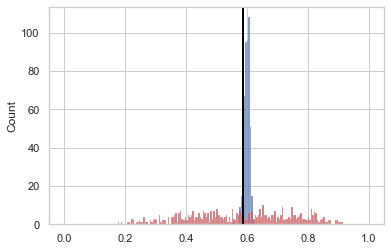

In [6]:
obs_dxy =  0.58566
sns.histplot(sim_dxy_bg, color= 'b', binwidth = 0.005, binrange = [0,1])
sns.histplot(sim_dxy_0rec, color= 'r', binwidth = 0.005, binrange = [0,1])
plt.axvline(x =  0.58566, linewidth=2, color ='black')
plt.show()

What is the distribution of $F_{ST}$ if we assume only gene conversion happens? I am assuming a mean GC tract lenth of 100 bases (probably too long for Drosophila)

In [4]:
replicates_GC = msprime.sim_ancestry(samples={"Dmon": sample_size_mon, "Dfla" : sample_size_fla}, 
                            sequence_length = 100_000, recombination_rate=0, 
                            gene_conversion_rate= 3.59E-08, gene_conversion_tract_length=390,
                            random_seed = 123, demography=demography, num_replicates = num_rep)

In [5]:
#Specify mu
mu = 2.8e-9
sim_dxy_GC = np.zeros(num_rep)
# Use this loop to sim mutations for each replicate and record fst
for replicate_index, ts in enumerate(replicates_GC):
# Defining sample sets for the two populations. NOTE: each diploid sample contains two lineages, i.e. the index of samples from
# Dmon is [0:18]     
    A = ts.samples()[0:18]
    B = ts.samples()[18:36]
    ts_muts = msprime.sim_mutations(ts, rate=mu, random_seed=92)
    sim_dxy_GC[replicate_index] = ts_muts.Fst(sample_sets=[A, B])

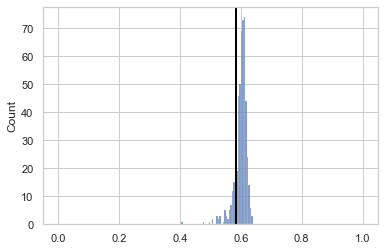

In [6]:
obs_dxy =  0.58566
sns.histplot(sim_dxy_GC, color= 'b', binwidth = 0.005, binrange = [0,1])
plt.axvline(x =  obs_dxy, linewidth=2, color ='black')
plt.show()

We can use the distribution of $F_{ST}$ across sim replicates to find the p value for any observed increase $F_{ST}$ in inverted region; i.e. let's say we observed $F_{ST} = 0.059295$ in the 4 inversion: 

In [7]:
inv4dxy = 0.59295
greater = sim_dxy_GC > inv4dxy
greater.sum()/500

0.752

In [8]:
inv5dxy = 0.61096
greater = sim_dxy_GC > inv5dxy
greater.sum()/500

0.29

The problem is coming up with a minimal model of recombination in inversions that is simple, can be simulated and is conservative. The hope would be that $d_{xy}$ an inversion is significantly higher even if we base significance on sims under a really drastic model: e.g. sequences that recombine less and are shorter than the real inversions...